# Understanding A/B testing through Monte Carlo simulation

**Work description**

In this paper, we discuss two samples with different conversions. Each sample consists of numbers 1 and 0 in some proportion, where 1 is the target action. 

We will conduct proportional tests. The purpose of the tests is to determine whether the samples belong to the same general population or not. 

Lets formulate the null hypothesis:

**H0: there is no difference beetween samples (samples belong to the same general population)**

We will conduct A/A and A/B tests with the following methods:
- Monte Carlo
- T-test
- Z-test

**Objectives of the work:**
- understand how to simulate a test of proportions using Monte Carlo
- imagine the distribution of p-values in different cases
- intuitivly and logically understand the terms such as power, significance level, p-value and relationship between them

**Assumptions**

If the power or significance level of the simulated test (Monte-Carlo) differs from the expected parameters for a given sample size by more then 20 percent, then we will assume that the p-value generator is designed incorrectly.

In [1]:
import pandas as pd 
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import zt_ind_solve_power
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind, mannwhitneyu

from tqdm.notebook import tqdm

In [2]:
plt.style.use('dark_background')

## Setting the parameters of the samples

<a id='settings'></a>

In [3]:
mde = 0.05 # minimum detectable effect 5%
baseline = 0.2 # baseline conversion rate 20%
power = 0.8 # statistical power of the test 80%
alpha = 0.05 # significance level of the test 5%

In [4]:
# calculate sample size
es = sms.proportion_effectsize(baseline, baseline+mde)

sample_size = round(sms.NormalIndPower().solve_power(es, power=power, alpha=alpha, ratio=1))
sample_size

1092

In [5]:
# creating an `a` sample generator
def a():
    ''' Create a sample with baseline
    '''
    return np.random.binomial(1, baseline, size=sample_size)

In [6]:
# creating a `b` sample generator
def b():
    ''' Create a sample with baseline+mde
    '''
    return np.random.binomial(1, baseline+mde, size=sample_size)

## Monte-Carlo

**We will conduct an A/B test.**

In [7]:
# create list for p-values
p_values = []

# create loop for p-values calculations
for _ in tqdm(range(1_000)):
    
    # generate two samples with unequal chances to get the same conversion
    sample_a = a()
    sample_b = b()
    
    # calculate the modulus of the difference between the samples conversions
    diff = abs(sample_a.mean() - sample_b.mean())
    
    # we assume, that the values of two samples belong to the same general population
    # calculate the conversion of the combined samples
    general_conversion = np.concatenate([sample_a, sample_b]).mean()
    
    # create a function, that generates a sample with a conversion as in the combined samples
    def general_sample():
        return np.mean(np.random.binomial(1, general_conversion, sample_size))
    
    # calculate p value
    
    # in this case p-value is: the percentage of cases, when 
        # the conversion difference between the same combined samples is greater then or equal to
        # the conversion difference between sample `a` and sample `b`
    p_value = np.mean([abs(general_sample() - general_sample()) >= diff for _ in range(1_000)])
    
    p_values.append(p_value)

# convert list to Series
p_values = pd.Series(p_values)

  0%|          | 0/1000 [00:00<?, ?it/s]

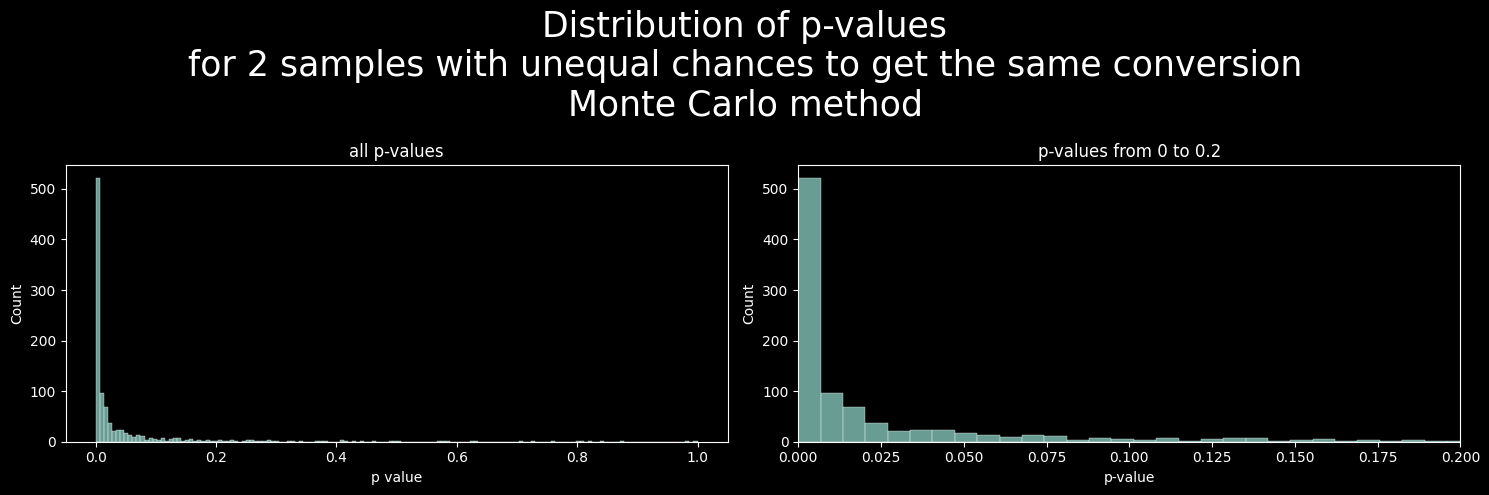

In [8]:
# create histograms of the distribution of p-values
figure, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(p_values, ax=axes[0])
sns.histplot(p_values, ax=axes[1])
axes[1].set_xlim(0,0.2)
axes[1].set_xlabel('p-value')
axes[1].set_title('p-values from 0 to 0.2')
axes[0].set_title('all p-values')
axes[0].set_xlabel('p value')
plt.suptitle('Distribution of p-values\nfor 2 samples with unequal\
 chances to get the same conversion\nMonte Carlo method', fontsize=25)

plt.tight_layout()
plt.show()

It is the Puasson distribution. This is logical, since we planned to reject most of the incorrect null hypotheses, and for this we need to get a lot of p-values less then alpha (0.05). And we can see a long rare tail on the right hand. These are incorrect null hypotheses that we have not rejcected.

In [9]:
fact_power = round(np.mean([p_values < alpha]) * 100, 3)

In [10]:
print(f'The power of our test is equal to {fact_power}%.')

The power of our test is equal to 79.6%.


In [11]:
print(f'This means, that in {fact_power}% cases we detected the difference in conversions, assuming it exists.')

This means, that in 79.6% cases we detected the difference in conversions, assuming it exists.


In [12]:
diff_power = round(abs(power*100 - fact_power), 3)

In [13]:
print(f'The difference between the planned power and the actual power is equal to {diff_power}%\
\nThis is a relative difference of {round(diff_power/power,3)}%.')

The difference between the planned power and the actual power is equal to 0.4%
This is a relative difference of 0.5%.


We did not get a big difference between the planned and actual power, hence our simulation of A/B test is correct.

**Next we will conduct A/A test.**

In [14]:
# create list for p-values
p_values = []

# create list for the modulus of the difference between the samples conversions
difference = []

# create loop for p-values calculations
for _ in tqdm(range(1_000)):
    
    # generate two samples with equal chances to get the same conversion
    sample_a = a()
    sample_b = a()
    
    # calculate the modulus of the difference between the samples conversions
    diff = abs(sample_a.mean() - sample_b.mean())
    
    # we assume, that the values of two samples belong to the same general population
    # calculate the conversion of the combined samples
    general_conversion = np.concatenate([sample_a, sample_b]).mean()
    
    # create a function, that generates a sample with a conversion as in the combined samples
    def general_sample():
        return np.mean(np.random.binomial(1, general_conversion, sample_size))
    
    # calculate p-value
    
    # in this case p-value is: the percentage of cases, when 
        # the conversion difference between the same combined samples is greater then or equal to
        # the conversion difference between sample `a` and sample `b`
    p_value = np.mean([abs(general_sample() - general_sample()) >= diff for _ in range(1_000)])
    
    p_values.append(p_value)
    difference.append(diff)

# convert list to Series
p_values = pd.Series(p_values)
# convert list to DataFrame
difference = pd.DataFrame(difference, columns=['difference'])

  0%|          | 0/1000 [00:00<?, ?it/s]

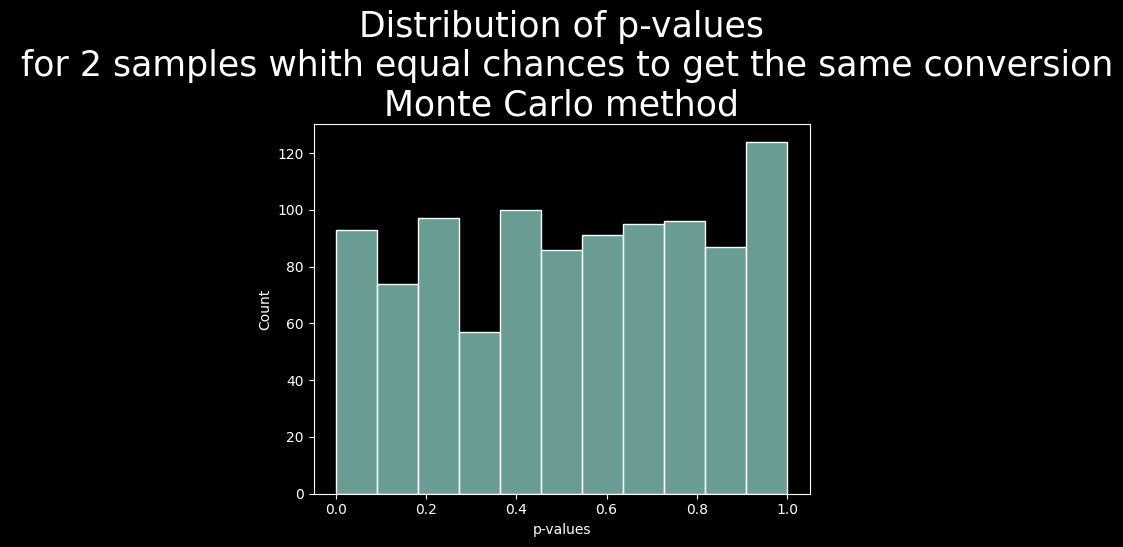

In [15]:
# create histogram of the distribution of p-values
sns.histplot(p_values)
plt.xlabel('p-values')
plt.title('Distribution of p-values\n for 2 samples whith equal chances\
 to get the same conversion\nMonte Carlo method', fontsize=25)
plt.show()

It is the normal distribution. We will not look for a mathematical explanation for this, but we will try to understand why everything works like this.

> The reason for this is really the definition of alpha as the probability of a type I error. We want the probability of rejecting a true null hypothesis to be alpha, we reject when the observed p-value<α, the only way this happens for any value of alpha is when the p-value comes from a uniform distribution. [quote from](https://stats.stackexchange.com/questions/10613/why-are-p-values-uniformly-distributed-under-the-null-hypothesis)

Now we record modules of the difference between the samples conversions. Lets observe histogramm of these values.

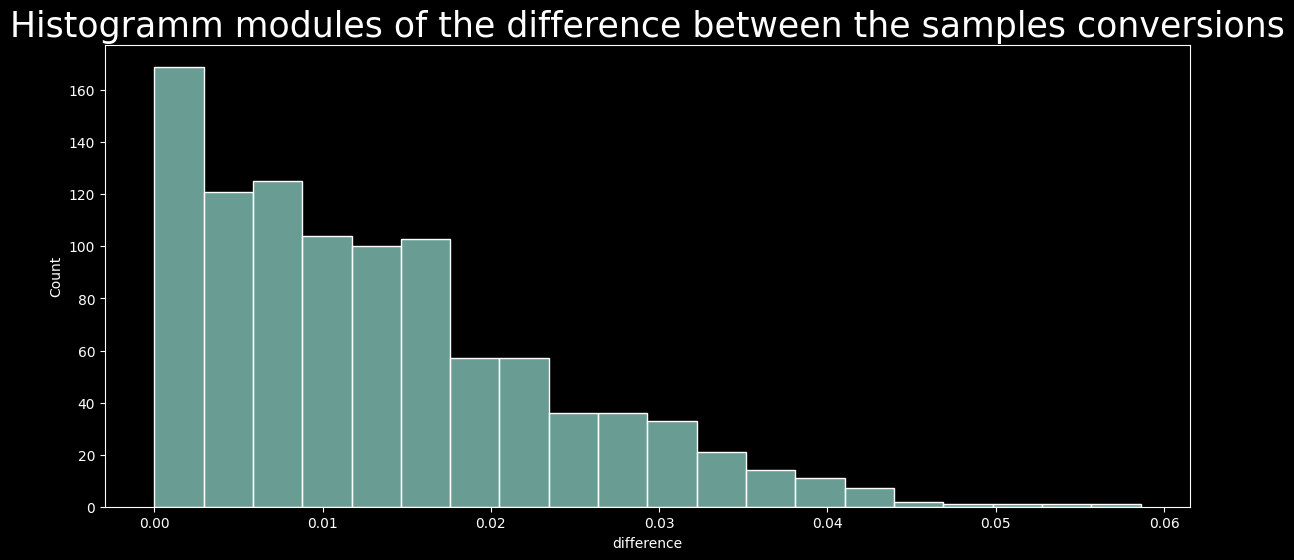

In [16]:
plt.figure(figsize=(14, 6))
sns.histplot(difference['difference'])
plt.title('Histogramm modules of the difference between the samples conversions', fontsize=25)
plt.show()

It is the Puasson distribution.

Futher, for convenience, we will call `modules of the difference between the samples conversions` like `diff`.

**`diff` and p-values relate**

Another important point for intuitive understanding is how the values of diff and p-values relate. For example, which interval `diff` corresponds to the interval between 0 to 0.1 p-values, and which from 0.9 to 1?

Since the p-values have a uniform distribution, each equal interval has an equal number of values. Remember this.

Lets look at the relationship beetween the p-value and the `diff`. The smaller the value of the p-values, the greater the `diff` will be, since the more the samples differ, the less likely they belong to the same general population.

Therefore, in each interval of the p-value, we should get an equal amount of `diff`, where a smaller p-value will correspond to a larger `diff`.

**Divide the `diff` into 10 equal quantiles and display this on the histogram.**

Assumption: in fact, the `diff` will not be divided exactly by quantiles, since the distribution is not uniform but close to uniform, we will ignore this point.

In [17]:
# devide the data into 10 quantiles
difference['ten_quantiles'] = pd.qcut(difference['difference'], 10)
# find the boundaries of the quantile values 
ten_quantiles = difference['ten_quantiles'].value_counts().sort_index()

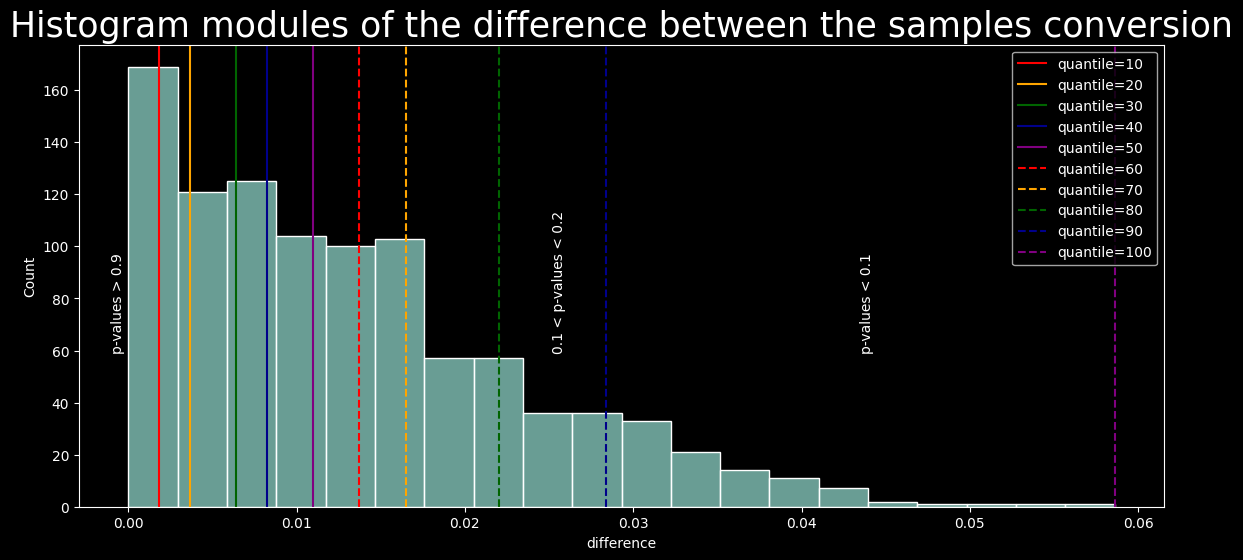

In [18]:
plt.figure(figsize=(14, 6))
sns.histplot(difference['difference'])
plt.axvline(x=ten_quantiles.index.values[0].right, color='red', label='quantile=10')
plt.axvline(x=ten_quantiles.index.values[1].right, color='orange', label='quantile=20')
plt.axvline(x=ten_quantiles.index.values[2].right, color='darkgreen', label='quantile=30')
plt.axvline(x=ten_quantiles.index.values[3].right, color='darkblue', label='quantile=40')
plt.axvline(x=ten_quantiles.index.values[4].right, color='purple', label='quantile=50')
plt.axvline(x=ten_quantiles.index.values[5].right, linestyle='dashed', color='red', label='quantile=60')
plt.axvline(x=ten_quantiles.index.values[6].right, linestyle='dashed', color='orange', label='quantile=70')
plt.axvline(x=ten_quantiles.index.values[7].right, linestyle='dashed', color='darkgreen', label='quantile=80')
plt.axvline(x=ten_quantiles.index.values[8].right, linestyle='dashed', color='darkblue', label='quantile=90')
plt.axvline(x=ten_quantiles.index.values[9].right, linestyle='dashed', color='purple', label='quantile=100')
plt.legend()
plt.text(abs(ten_quantiles.index.values[8].right + ten_quantiles.index.values[9].right)/2, 60, 
         'p-values < 0.1',rotation='vertical')
plt.text((ten_quantiles.index.values[7].right + ten_quantiles.index.values[8].right)/2, 60, 
         '0.1 < p-values < 0.2', rotation='vertical')
plt.text(ten_quantiles.index.values[0].left, 60, 
         'p-values > 0.9 ', rotation='vertical')
plt.title('Histogram modules of the difference between the samples conversion', fontsize=25)
plt.show()

Now we can observe how each subsequent quantile includes an increasing range of `diff`. That is, we get large number of `diff` values near zero, which is logical, since both samples have equal chances to get equal conversions. Also we see the tail of the values where we got rarely probable events.

As noted in the graph, quantile `diff` > 90 corresponds to the values of quantile p-value < 0.1 and so on.

In [19]:
fact_alpha = round(np.mean([p_values < alpha])*100, 3)

In [20]:
print(f'The alpha of our test is equal to {fact_alpha}%.')

The alpha of our test is equal to 4.8%.


In [21]:
print(f'This means, that in {fact_alpha}% cases we detected\
 the difference in conversions, assumig one does not exist.')

This means, that in 4.8% cases we detected the difference in conversions, assumig one does not exist.


In [22]:
diff_alpha = round(abs(alpha*100 - fact_alpha), 3)
print(f'Difference between the planned alpha and the actual alpha is equal to {diff_alpha}\
\nIt is {round(diff_alpha/alpha,3)}% relative difference.')

Difference between the planned alpha and the actual alpha is equal to 0.2
It is 4.0% relative difference.


We did not get a big difference between the planned and actual alpha, hence our simulation of A/A test is correct.

## Monte Carlo - z-test

**We will conduct A/B test.**

In [23]:
p_values = []
for _ in tqdm(range(1_000)):
    _, p_value = proportions_ztest([a().sum(), b().sum()], [len(a()), len(b())])
    
    p_values.append(p_value)

p_values = pd.Series(p_values)

  0%|          | 0/1000 [00:00<?, ?it/s]

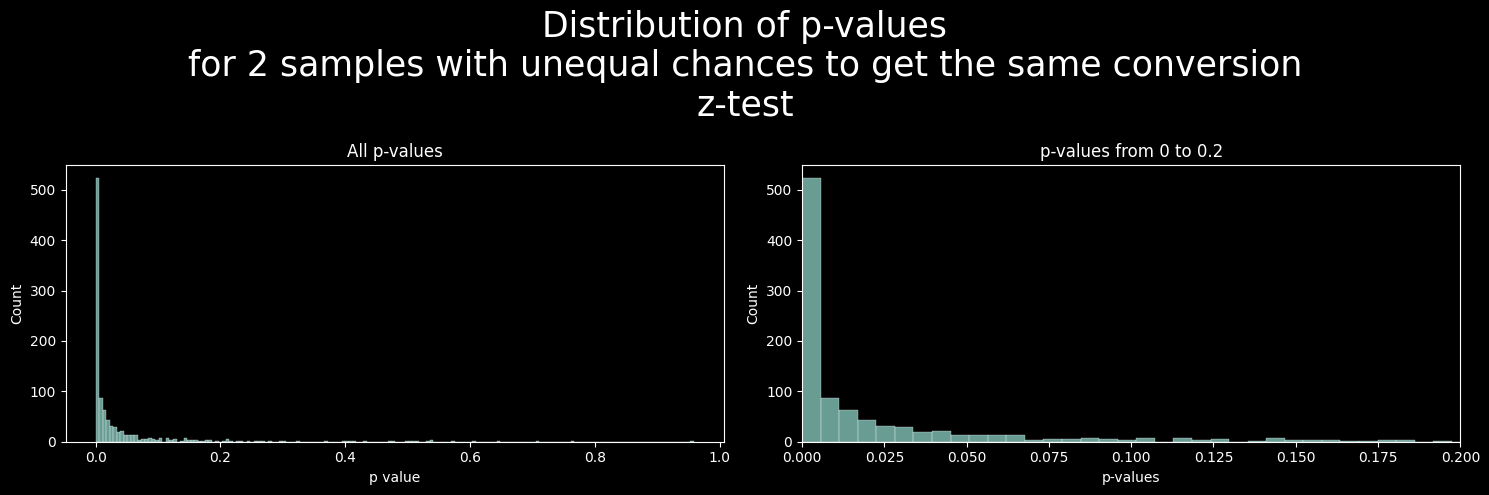

In [24]:
# create histogram of the distribution of p-values
figure, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(p_values, ax=axes[0])
sns.histplot(p_values, ax=axes[1])
axes[1].set_xlim(0,0.2)
axes[1].set_xlabel('p-values')
axes[1].set_title('p-values from 0 to 0.2')
axes[0].set_title('All p-values')
axes[0].set_xlabel('p value')
plt.suptitle('Distribution of p-values\nfor 2 samples with unequal chances to get the same conversion\
\nz-test', fontsize=25)
plt.tight_layout()
plt.show()

In [25]:
fact_power = round(np.mean([p_values < alpha]) * 100, 3)

In [26]:
print(f'The power of our test is equal to {fact_power}%.')

The power of our test is equal to 83.0%.


In [27]:
print(f'This means, that in {fact_power}% cases we detected the difference in conversions, assuming it exists.')

This means, that in 83.0% cases we detected the difference in conversions, assuming it exists.


In [28]:
diff_power = round(abs(power*100 - fact_power), 3)

In [29]:
print(f'Difference between the planned power and the actual power is equal to {diff_power}%\
\nThis is a {round(diff_power/power,3)}% relative difference.')

Difference between the planned power and the actual power is equal to 3.0%
This is a 3.75% relative difference.


We did not get a big difference between the planned and actual power, hence our simulation of A/B test is correct.

**Next we will conduct A/A test.**

In [30]:
p_values = []
for _ in tqdm(range(1_000)):
    _, p_value = proportions_ztest([a().sum(), a().sum()], [len(a()), len(a())])
    
    p_values.append(p_value)

p_values = pd.Series(p_values)

  0%|          | 0/1000 [00:00<?, ?it/s]

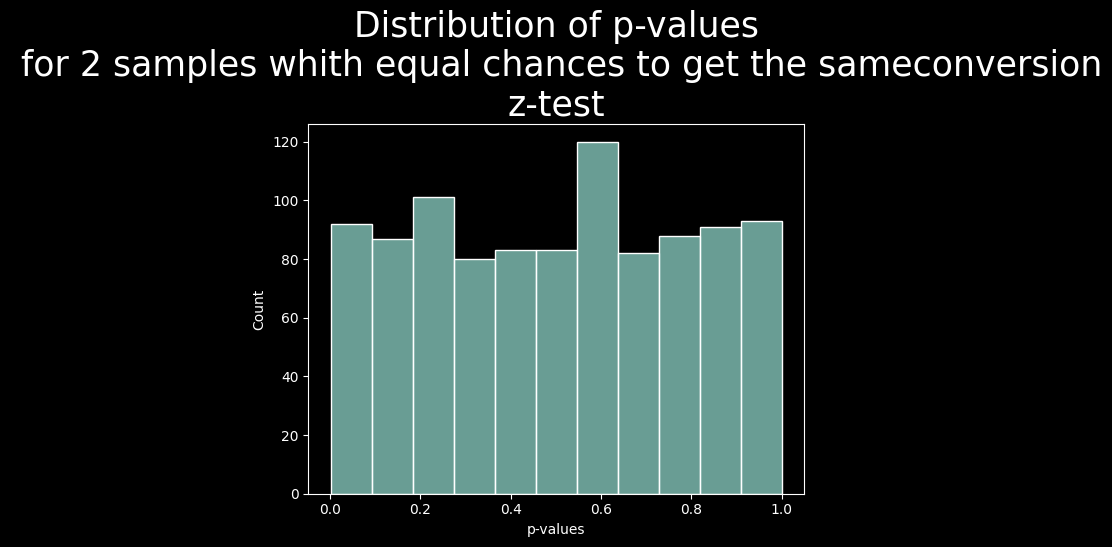

In [31]:
# create histogram of the distribution of p-values
sns.histplot(p_values)
plt.xlabel('p-values')
plt.title('Distribution of p-values\n for 2 samples whith equal chances to get the same\
conversion\nz-test', fontsize=25)
plt.show()

In [32]:
fact_alpha = round(np.mean([p_values < alpha])*100, 3)

In [33]:
print(f'The alpha of our test is equal to {fact_alpha}%.')

The alpha of our test is equal to 4.7%.


In [34]:
print(f'This means, that in {fact_alpha}% we detected the difference in conversions, assumig one does not exist.')

This means, that in 4.7% we detected the difference in conversions, assumig one does not exist.


In [35]:
diff_alpha = round(abs(alpha*100 - fact_alpha), 3)
print(f'Difference between the planned alpha and the actual alpha is equal to {diff_alpha}\
\nIt is {round(diff_alpha/alpha,3)}% relative difference.')

Difference between the planned alpha and the actual alpha is equal to 0.3
It is 6.0% relative difference.


We did not get a big difference between the planned and actual alpha, hence our simulation of A/A test is correct.

## Monte Carlo - t-test

**We will conduct A/B test.**

In [36]:
p_values = []
for _ in tqdm(range(1_000)):
    _, p_value = ttest_ind(a(), b(), equal_var=False)
    
    p_values.append(p_value)

p_values = pd.Series(p_values)

  0%|          | 0/1000 [00:00<?, ?it/s]

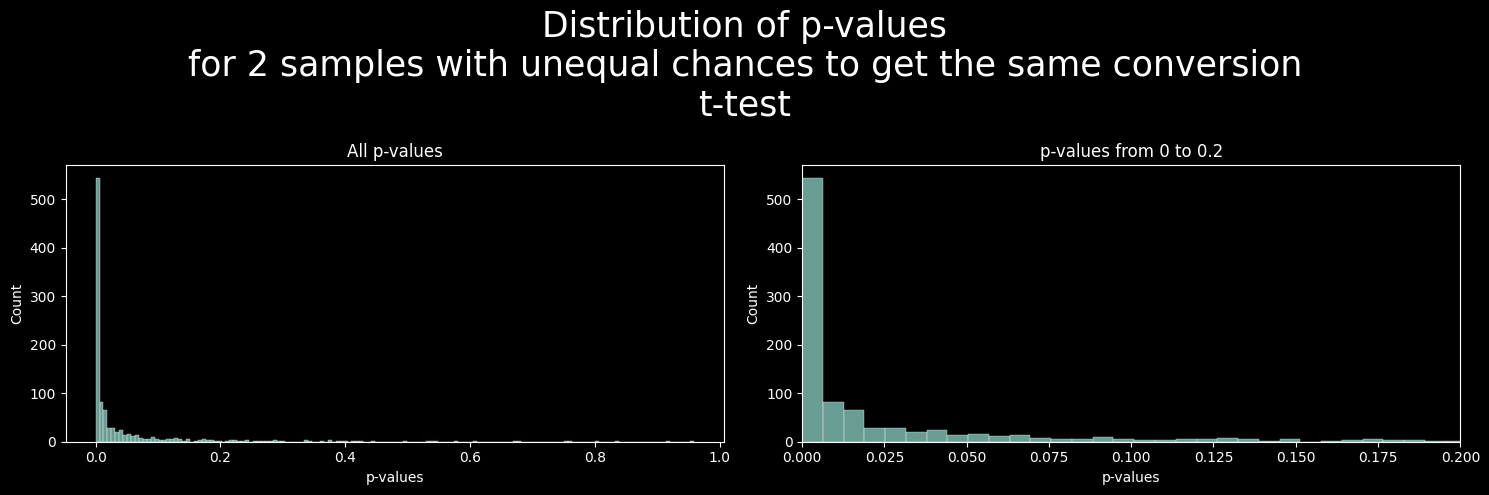

In [37]:
# create histogram of the distribution of p-values
figure, axes = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(p_values, ax=axes[0])
sns.histplot(p_values, ax=axes[1])
axes[1].set_xlim(0,0.2)
axes[1].set_xlabel('p-values')
axes[1].set_title('p-values from 0 to 0.2')
axes[0].set_title('All p-values')
axes[0].set_xlabel('p-values')
plt.suptitle('Distribution of p-values\nfor 2 samples with unequal chances to get the same conversion\
\nt-test', fontsize=25)
plt.tight_layout()
plt.show()

In [38]:
fact_power = round(np.mean([p_values < alpha]) * 100, 3)

In [39]:
print(f'The power of our test is equal to {fact_power}%.')

The power of our test is equal to 80.5%.


In [40]:
print(f'This means, that in {fact_power}% cases we detect the difference in conversions, assuming it exists.')

This means, that in 80.5% cases we detect the difference in conversions, assuming it exists.


In [41]:
diff_power = round(abs(power*100 - fact_power), 3)

In [42]:
print(f'Difference between the planned power and the actual power is equal to {diff_power}%\
\nThis is a {round(diff_power/(power),3)}% relative difference.')

Difference between the planned power and the actual power is equal to 0.5%
This is a 0.625% relative difference.


We did not get a big difference between the planned and actual power, hence our simulation of a/b test is correct.

**Next we will conduct A/A test.**

In [43]:
p_values = []
for _ in tqdm(range(1_000)):
    _, p_value = ttest_ind(a(), a(), equal_var=False)
    
    p_values.append(p_value)

p_values = pd.Series(p_values)

  0%|          | 0/1000 [00:00<?, ?it/s]

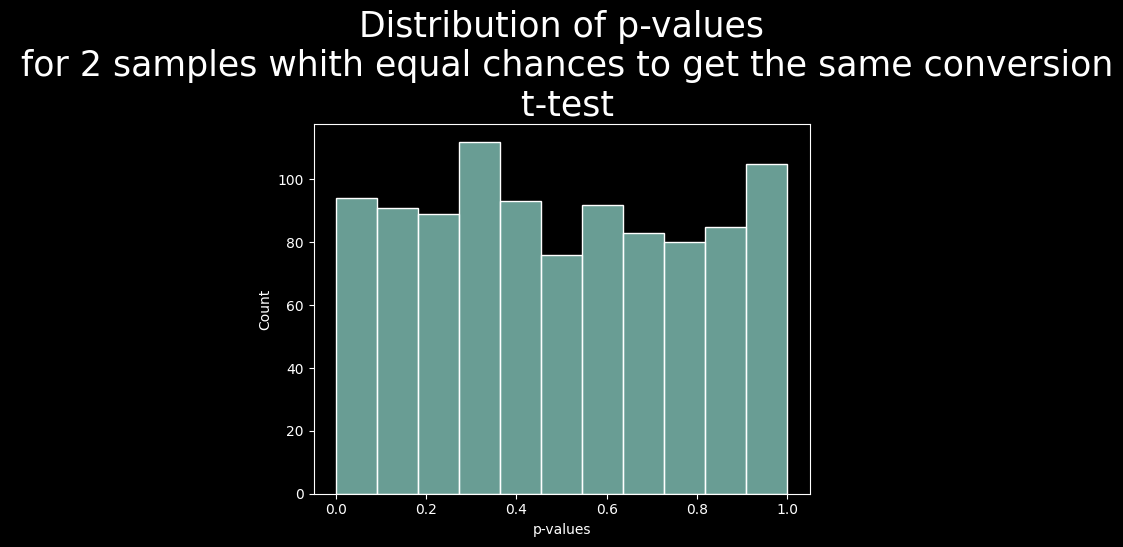

In [44]:
# create histogram of the distribution of p values
sns.histplot(p_values)
plt.xlabel('p-values')
plt.title('Distribution of p-values\n for 2 samples whith equal chances to get the same conversion\
\n t-test', fontsize=25)
plt.show()

In [45]:
fact_alpha = round(np.mean([p_values < alpha])*100, 3)

In [46]:
print(f'The alpha of our test is equal to {fact_alpha}%.')

The alpha of our test is equal to 4.8%.


In [47]:
print(f'This means, that in {fact_alpha}% we detected the difference in conversions, assumig one does not exist.')

This means, that in 4.8% we detected the difference in conversions, assumig one does not exist.


In [48]:
diff_alpha = round(abs(alpha*100 - fact_alpha), 3)
print(f'Difference between the planned alpha and the actual alpha is equal to {diff_alpha}\
\nIt is {round(diff_alpha/(alpha),3)}% relative difference.')

Difference between the planned alpha and the actual alpha is equal to 0.2
It is 4.0% relative difference.


We did not get a big difference between the planned and actual alpha, hence our simulation of A/A test is correct.

## Conclusion

We did not get a big difference between the planned and the actual power, the planned and the actual alpha, from this we can conclude that we correctly conducted the simulation of the test.

I hope that for those who have viewed this notebook, the testing has become a little clearer.

If you want to play with different alpha and power values, you can confidently [change these numbers](#settings), and the entire notebook will be calculated with these settings.